# Emergence of space in hexgonal gridworlds.

In this notebook, we will show how space emerges by interacting with the environment.
And because square grid worlds are boring, and continuous worlds take too long to train, we will create an hexagonal world.

## Environment

The environment is a random hexagonal grid (because why not?), composed of cells.
Each cell is either:
- a non-traversable obstacle (value 1)
- empty (value 0)

Each non-empty cell is represented by a random values between 50 and 255. There is no association between the color of the cell and its nature.
Agent cell is represente by value 42.

## Agent

The orientation on te grid is 0,1, ... 5. 0 is the orientation facing right. Angles are changes in a trigonometric fashion.
The agent occupies a single cell. At each step, it can rotate by left or right or stay at the same orientation. It can then move forward by N cell. It always faces a cell directly in front of it, and perceives the grids on a 120 degrees cone in front of it, at a certain range.

## Objects

No objects in the first verion, just obstacles.
In future versions, we will add objects which can move, and objects which can be pushed.

## Engine

A step happens as follows:
- agent moves
- returns observations.

# 1 - Building the environment

## 2 - Generate sensorimotor interactions

The agent perceives in a 120 degrees cone in front of it.

At each timestep, it chooses a random action, moves, and receives an observation.


In [11]:
from hexa_world.hexa_world import ActionSampler, HexaWorld

hexa = HexaWorld(30, ratio_obstacles=0.3, range_observation=5)
action_sampler = ActionSampler(4)


## Random action sampler to sample uniformly the displacement over space

In [12]:
from collections import namedtuple
import random
import time

dataset = []

DataPoint = namedtuple('DataPoint', ['position', 'a', 'o'])

t_start = time.time()
for step in range(int(2e5)):
    angle, forward = action_sampler.sample()
    
    pos = hexa.position_agent
    
    obs = hexa.step(angle, forward)
    
    point = DataPoint(pos, [angle, forward], obs)
    
    dataset.append(point)

print( 2e5/(time.time() - t_start))

27701.5901667143


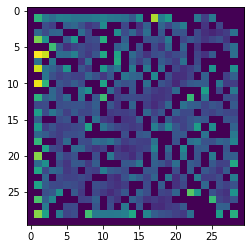

In [13]:
import matplotlib.pyplot as plt
import numpy as np

vis = np.zeros((30,30))

for pt in dataset:
    vis[pt.position[0], pt.position[1]] += 1
    
plt.imshow(vis)

## Build a dataset

Use pytorch dataloader utilities to make train/test dataset.

In [14]:
from torch.utils.data import Dataset, DataLoader
import torch
import math

Displacement = namedtuple('Displacement', ['long', 'lat', 'theta', 'r', 'orientation'])


class HexaDS(Dataset):
    
    def __init__(self, sm_points, t_encode, t_predict, onehot=False, onehot_length=8):
        
        self.points = sm_points
        self.t_encode = t_encode
        self.t_predict = t_predict
        self.onehot = onehot
        self.onehot_length = onehot_length
        
    def __len__(self):
        
        return len(self.points) - self.t_encode - self.t_predict - 2
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        obs_past = np.asarray([self.points[i].o for i in range(idx, idx+self.t_encode)])
        act_past = np.asarray([self.points[i].a for i in range(idx, idx+self.t_encode)])
        
        obs_past_shifted = np.asarray([self.points[i].o for i in range(idx+1, idx+self.t_encode+1)])
        act_past_shifted = np.asarray([self.points[i].a for i in range(idx+1, idx+self.t_encode+1)])
        
        obs_future = np.asarray([self.points[i].o for i in range(idx+self.t_encode, idx+self.t_encode+self.t_predict+1)])
        act_future = np.asarray([self.points[i].a for i in range(idx+self.t_encode, idx+self.t_encode+self.t_predict+1)])
        
        if self.onehot:
            obs_past = np.eye(self.onehot_length + 1)[(obs_past).reshape(-1)][:,1:].reshape((obs_past.shape[0], obs_past.shape[1], self.onehot_length))
            obs_future = np.eye(self.onehot_length + 1)[(obs_future).reshape(-1)][:,1:].reshape((obs_future.shape[0], obs_future.shape[1], self.onehot_length))
            
            obs_past_shifted = np.eye(self.onehot_length + 1)[(obs_past_shifted).reshape(-1)][:,1:].reshape((obs_past_shifted.shape[0], obs_past_shifted.shape[1], self.onehot_length))
            
            act_past_rot = np.eye(3)[act_past[:,0].reshape(-1) + 1].reshape(act_past.shape[0], 3)
            act_past_for = np.eye(2)[act_past[:,1].reshape(-1)].reshape(act_past.shape[0], 2)
            act_past = np.concatenate([act_past_for, act_past_rot], axis = 1)
            
            act_fut_rot = np.eye(3)[act_future[:,0].reshape(-1) + 1].reshape(act_future.shape[0], 3)
            act_fut_for = np.eye(2)[act_future[:,1].reshape(-1)].reshape(act_future.shape[0], 2)
            act_future = np.concatenate([act_fut_for, act_fut_rot], axis = 1)
            
            act_shift_rot = np.eye(3)[act_past_shifted[:,0].reshape(-1) + 1].reshape(act_past_shifted.shape[0], 3)
            act_shift_for = np.eye(2)[act_past_shifted[:,1].reshape(-1)].reshape(act_past_shifted.shape[0], 2)
            act_past_shifted = np.concatenate([act_shift_for, act_shift_rot], axis = 1)
            
        pos_pres = self.points[idx + self.t_encode - 1 ].position
        pos_final = self.points[idx + self.t_encode + self.t_predict ].position
        
        x_0, y_0, angle_0 = pos_pres
        x_1, y_1, angle_1 = pos_final
        
        if x_0 % 2 == 1:
            y_0 += 0.5
        if x_1 % 2 == 1:
            y_1 += 0.5
        
        dx = (x_1 - x_0)*math.sqrt(3)/2
        dy = (y_1 - y_0)
        r = (dx**2 + dy**2)**(1/2)
        theta = math.atan2(dy, dx)%(2*math.pi)
        
        angle_0 = math.radians(angle_0 * 60 + 90)%(2*math.pi)
        angle_1 = math.radians(angle_1 * 60 + 90)%(2*math.pi)
        
        angle_displacement = theta - angle_0
        longitudinal_displacement = r*math.cos(angle_displacement)
        lateral_displacement = r*math.sin(angle_displacement)
        
        d_orientation = (angle_1 - angle_0)%(2*math.pi)
        disp = Displacement(longitudinal_displacement,
                           lateral_displacement,
                           theta, r,
                           d_orientation)
        
        sample = {  'obs_past': obs_past,
                    'act_past': act_past,
                    'obs_past_shifted': obs_past_shifted,
                    'act_past_shifted': act_past_shifted,
                    'obs_future': obs_future,
                    'act_future': act_future,
                    'displacement': disp
                 }
            
        return sample
            

In [15]:
hexa_ds = HexaDS(dataset, 15, 3, onehot=False)


In [16]:
from torch.utils.data.sampler import SubsetRandomSampler

batch_size = 64
validation_split = .2
all_indices = list(range(len(hexa_ds)))
split = int( validation_split * len(hexa_ds) )

train_indices, val_indices = all_indices[split:], all_indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(hexa_ds, batch_size=batch_size, 
                                           sampler=train_sampler, drop_last=True)
eval_loader = torch.utils.data.DataLoader(hexa_ds, batch_size=batch_size,
                                                sampler=valid_sampler, drop_last=True)

## Now that we have a dataset, we will build networks to perform self-supervised prediction

## 1 - Sensorimotor prediction to encode a state

In [17]:
import torch.nn as nn
import torch.nn.functional as F

class DisplacementNet(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        # Encoding Sensorimotor Data
        self.sm_encoder = nn.LSTM(input_size = 36+2, hidden_size = 256, num_layers = 2)
        
        # Predicting next sensor
        self.fc_prediction_1 = nn.Linear(256 + 2, 128)
        self.fc_prediction_2 = nn.Linear(128, 36)
        
        # Encoding Actions into displacement
        self.fc_sm_context = nn.Linear(256, 64)
        self.action_encoder = nn.GRU(2, 64, 1)
        self.fc_disp = nn.Linear(64, 32)
        
        # forward
        self.pred_o_1 = nn.Linear(256 + 32, 128)
        self.pred_o_2 = nn.Linear(128, 128)
        self.pred_o_3 = nn.Linear(128, 36)
        
        # backward
        self.pred_a_1 = nn.Linear(256 + 36, 128)
        self.pred_a_2 = nn.Linear(128, 128)
        self.pred_a_3 = nn.Linear(128, 32) 
        
    def encode_sm(self, o_past, a_past):
        
        input_encoder = torch.cat([o_past, a_past], 2).permute(1,0,2)
        
        encoded_state = self.sm_encoder(input_encoder)[0]
        
        return encoded_state
        
        
    def predict_shift(self, o_past, a_past, a_shift):
                
        encoded_state = self.encode_sm(o_past, a_past)
        
        input_pred = torch.cat([encoded_state, a_shift.permute(1,0,2)], 2)
        pred_s = F.relu(self.fc_prediction_1(input_pred))
        pred_s_shift = F.relu(self.fc_prediction_2(pred_s))
        
        return pred_s_shift
    
    def encode_displacement(self, state, a):
        
        a = a.permute(1,0,2)
        initial_state_gru = F.relu( self.fc_sm_context(state) ).view(1, batch_size, -1)
        encoded_actions = self.action_encoder(a, initial_state_gru)[0][-1]
        displacement = self.fc_disp(encoded_actions)
        
        return displacement
        
    
    def forward(self, o_past, a_past, a_future):
        
        state = self.encode_sm(o_past, a_past)[-1]
        displacement = self.encode_displacement(state, a_future)
        
        pred = torch.cat([state, displacement], 1)
        pred = F.relu(self.pred_o_1(pred))
        pred = F.relu(self.pred_o_2(pred))
        predicted_observation = F.relu(self.pred_o_3(pred)).view(-1, 36)
        
        return displacement, predicted_observation
        
        
    def inverse(self, o_past, a_past, o_future):
        
        state = self.encode_sm(o_past, a_past)[-1]
        
        o_future_flat = o_future.view(o_future.shape[0], -1)
  
        pred = torch.cat([state, o_future_flat], -1)
        pred = F.relu(self.pred_a_1(pred))
        pred = F.relu(self.pred_a_2(pred))
        pred_displacement = self.pred_a_3(pred)
                
        return pred_displacement
    
    
    def loss_shift(self, o_past, a_past, a_shift, obs_shift):

        predicted_obs_shift = self.predict_shift( o_past, a_past, a_shift )
       
        loss_reco = F.mse_loss(obs_shift.permute(1,0,2), predicted_obs_shift, reduction='mean')
    
        return loss_reco
    
    
    def loss_displacement( self, o_past, a_past, o_future, a_future):

    
        encoded_displacement, pred_o_future = self.forward(o_past, a_past, a_future)
        
        predicted_displacement = self.inverse(o_past, a_past, o_future)
        
    
        loss_forward = F.mse_loss(o_future, pred_o_future, reduction='mean')
        
        loss_inverse = F.mse_loss(encoded_displacement, predicted_displacement, reduction='mean')

        return loss_forward, loss_inverse
    
    
    


In [18]:

model = DisplacementNet()
optimizer = torch.optim.SGD(model.parameters(), lr=0.00001)


In [19]:
def train():

    model.train()

    for i, batch in enumerate(train_loader):


        o_past = batch['obs_past'].float()
        act_past = batch['act_past'].float()

        o_shift = batch['obs_past_shifted'].float()
        act_shift = batch['act_past_shifted'].float()
        
        act_future = batch['act_future'].float()
        obs_future = batch['obs_future'].permute(1,0,2)[-1].float()

        loss_shift = model.loss_shift( o_past, act_past, act_shift, o_shift)
        loss_forward, loss_inverse = model.loss_displacement(o_past, act_past, obs_future, act_future)

        if i%100 == 0:
            print('   train', i, loss_shift.item(), loss_forward.item(), loss_inverse.item())
        
        loss = loss_shift + loss_forward + loss_inverse
        loss.backward()
        optimizer.step()

In [20]:
def evaluate():
    model.eval() # Turn on the evaluation mode
    total_loss = [0,0,0]
    
    with torch.no_grad():
        for i, batch in enumerate(eval_loader):
            
            o_past = batch['obs_past'].float()
            act_past = batch['act_past'].float()

            o_shift = batch['obs_past_shifted'].float()
            act_shift = batch['act_past_shifted'].float()

            act_future = batch['act_future'].float()
            obs_future = batch['obs_future'].permute(1,0,2)[-1].float()

            loss_shift = model.loss_shift( o_past, act_past, act_shift, o_shift)
            loss_forward, loss_inverse = model.loss_displacement(o_past, act_past, obs_future, act_future)
            
            total_loss = [ x+y.item() for x,y in zip(total_loss, [loss_shift, loss_forward, loss_inverse]) ]
            
    total_loss = [x/len(eval_loader) for x in total_loss]        
    return total_loss

In [ ]:
for epoch in range(20):
    
    l = evaluate()
    print(epoch, l)
    train()

0 [0.27748712121198577, 0.2792589227692821, 0.01721171844893923]
   train 0 0.2677050232887268 0.2518300712108612 0.01699014939367771
   train 100 0.25002339482307434 0.24281880259513855 0.01700032874941826
   train 200 0.25451263785362244 0.24598711729049683 0.015582685358822346
   train 300 0.2510128319263458 0.25016888976097107 0.013682226650416851
   train 400 0.24026285111904144 0.2445421814918518 0.01176298875361681
   train 500 0.25015708804130554 0.2508811056613922 0.009160464629530907
   train 600 0.23048777878284454 0.2456684708595276 0.006632424425333738
   train 700 0.24952632188796997 0.25471973419189453 0.004526876844465733
   train 800 0.2247788906097412 0.22393420338630676 0.0028124158270657063
   train 900 0.21626436710357666 0.21889477968215942 0.0014194106915965676
   train 1000 0.22086046636104584 0.22228874266147614 0.0006226522382348776
   train 1100 0.20194625854492188 0.1972779482603073 0.0007020484190434217
   train 1200 0.18441861867904663 0.20061366260051727 

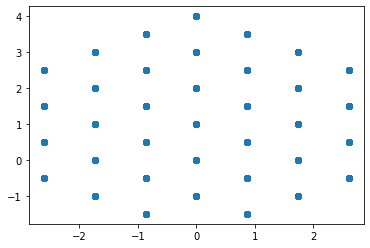

In [146]:
import matplotlib.pyplot as plt

X = []
Y = []
r=[]
theta=[]
disp_representation = []

for i, batch in enumerate(eval_loader):

    o_past = batch['obs_past'].float()
    act_past = batch['act_past'].float()

    o_shift = batch['obs_past_shifted'].float()
    act_shift = batch['act_past_shifted'].float()

    act_future = batch['act_future'].float()
    obs_future = batch['obs_future'].permute(1,0,2)[-1].float()
    disp = batch['displacement']


    encoded_disp, pred_obs = model.forward(o_past, act_past, act_future)
    
    X.append( disp.lat.numpy() )
    Y.append( disp.long.numpy() )
    r.append( disp.r.numpy() )
    theta.append( disp.theta.numpy() )
    
    
    disp_representation.append(encoded_disp.detach().numpy())
    
    
    
X = np.concatenate(X)
Y = np.concatenate(Y)
r = np.concatenate(r)
theta = np.concatenate(theta)


disp_representation = np.concatenate(disp_representation, axis = 0)

plt.scatter(X,Y)

In [147]:
from sklearn.decomposition import PCA

disp_projected = PCA(n_components=4).fit_transform(disp_representation)

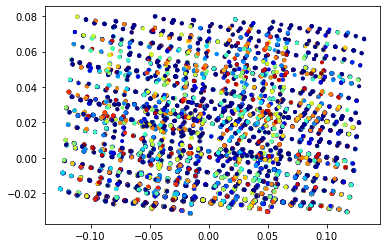

In [150]:

import matplotlib.cm as cm
from matplotlib.colors import Normalize
colormap = cm.jet

norm = Normalize()
norm.autoscale(theta)

cols = colormap(norm(theta))



plt.scatter(disp_projected[:, 0],disp_projected[:, 1], c = cols, marker = '.') 


In [149]:
for e in disp_representation:
    print(e)

[ 0.08380054  0.02354356  0.06665076 -0.08751705  0.14385395  0.01286565
 -0.05141216 -0.04253551 -0.00437716  0.03189625 -0.09513933 -0.01245175
 -0.02566778  0.09323952 -0.04239885 -0.04665788  0.00945421 -0.03290048
  0.00101513  0.04758147  0.03283427 -0.00469152 -0.13905782  0.00299683
  0.04763225  0.03611981  0.01427825 -0.00513258 -0.06749426  0.07386871
 -0.09050775  0.06946635]
[ 0.08224218  0.02519919  0.06378641 -0.07939705  0.14265503  0.02736848
 -0.03804016 -0.0340984  -0.00137662  0.03614365 -0.11003943 -0.00593791
 -0.02107634  0.08136903 -0.03127556 -0.05204681  0.01519655 -0.03922917
  0.00062658  0.04450615  0.02551728 -0.00738593 -0.14826573  0.01842723
  0.06348424  0.03922701  0.01406172 -0.00080578 -0.06789492  0.07084248
 -0.08857017  0.07371596]
[ 0.10202736  0.02461351  0.09439892 -0.10006031  0.13691461  0.01780814
 -0.03728583 -0.04268192  0.02513321  0.01883764 -0.1221538   0.00813484
 -0.04493123  0.07487023 -0.03656146 -0.05473294  0.01266895 -0.00578105

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




[ 0.0802172   0.03453249  0.06757203 -0.08382548  0.13395561  0.03017239
 -0.04016886 -0.042133    0.00126984  0.03720881 -0.1090313  -0.01110533
 -0.01937636  0.08410773 -0.02820734 -0.05127347  0.01047113 -0.0325255
 -0.0024042   0.04977224  0.02887079 -0.0010669  -0.1466538   0.00655098
  0.05431422  0.03568311  0.01984885  0.00046995 -0.06782433  0.06985231
 -0.08504791  0.07100772]
[ 8.9591056e-02  3.5780948e-02  8.4044307e-02 -9.5303245e-02
  1.3200864e-01  2.0662313e-02 -4.9816906e-02 -5.4349303e-02
  1.2457736e-02  2.8163197e-02 -1.0363553e-01 -7.6898304e-03
 -3.1397384e-02  8.7950230e-02 -3.5693068e-02 -4.9665168e-02
  4.8597427e-03 -1.4134731e-02 -1.2415275e-04  3.8627174e-02
  2.6704654e-02 -4.9277390e-03 -1.3770965e-01 -5.4165721e-04
  5.9023581e-02  2.9978829e-02  2.0588048e-02 -2.7295472e-03
 -5.1510371e-02  7.6819710e-02 -8.4273070e-02  6.4333133e-02]
[ 0.07673203  0.0426806   0.06603189 -0.08796023  0.1252555   0.02987127
 -0.05331656 -0.0555625  -0.00408957  0.0384044

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[ 8.80988687e-02  4.51562330e-02  8.74119252e-02 -9.90443528e-02
  1.22205466e-01  2.47928537e-02 -5.29242307e-02 -6.11739606e-02
  1.53040066e-02  2.79560070e-02 -1.01547047e-01 -1.31585076e-02
 -3.17314416e-02  8.94092694e-02 -3.08293961e-02 -5.07454835e-02
 -3.57014302e-04 -5.47743030e-03 -4.11168486e-03  4.31448594e-02
  2.94121504e-02 -8.18385743e-05 -1.36735529e-01 -1.43434033e-02
  4.93007004e-02  2.82326601e-02  2.64370032e-02 -7.03292899e-04
 -5.21452203e-02  7.65889287e-02 -8.06919336e-02  6.15468621e-02]
[ 0.10514631  0.02477418  0.09973161 -0.10289197  0.1368168   0.01748825
 -0.03797652 -0.04463562  0.03040829  0.0154852  -0.12366536  0.01097105
 -0.04942211  0.07343245 -0.0362082  -0.05634524  0.01227349  0.00027909
  0.01072485  0.00868507  0.00708682 -0.02463408 -0.13445961  0.02814606
  0.10231563  0.03473356  0.01146024 -0.00766747 -0.0244879   0.08763917
 -0.07770824  0.06616213]
[ 8.5110880e-02  3.8788475e-02  8.2176939e-02 -9.2166319e-02
  1.3306113e-01  2.1101836e